# ROC curves

ROC curves (also known as reciever operating characteristic curves) is a visual representation of 'how good' our binary classification model is. First of all, what do we mean by 'binary classification'? Imagine we have a set of data with two possible outcomes. In our case this may be benign and deleterious mutations. When we do 'binary classification' we essentially attempt to classify the benign mutations and the deleterious mutations. The ROC curve basically tells us how good our model is in doing this.

So how might this visualiation look? In ROC curves we plot a graph of something called the 'true positive rate' against the 'false positive rate'. Perhaps you may understand what they mean when you look at the name.

'True positive' means the data which has correctly been classed as positive by our model. Example, if we have a data `[0,0,0]`, and our model classes that data as `[0,0,0]`, then we have three true positives.

'False positive' on the other hand means that we have data which has incorrectly been classed as positive by our model. In our example above, for the data `[0,0,0]`, if our model classes this as `[0,1,0]` instead, then we would have one false positive.

But this is only half of it, as we need the **rates** of these so we can plot them. What we mean by the 'true positive rate' is the proportion of positive data correctly classed as positive data. Likewise, false postive rate means the proportion of positive data incorrectly classified.

$$TPR = \frac{TP}{TP+FN}$$

$$FPR = \frac{FP}{FP+TN}$$

where $TP$ stands for "true positive", $FP$ stands for "false positive", $FN$ stands for "false negative" and $TN$ stands for "true negative".

I believe that these rates could be interpreted as conditional probability. That would make sense because of their form and because they take values between 0 and 1, as we will see in the plots below.

### Imports

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch

### Gather properties of protein and structure
In the cell below we gather our data from the .csv file and also the structure of the protein which we are looking at.

PDB stands for "protein data bank". It's a publicly accessbile database which has the structures of lots of proteins. So the 2ac0 is basically an ID for the protein structure that this code is looking at. I believe the database which Python takes the information from is https://www.rcsb.org/. And we can search up 2ac0 on this website to get the 3d structure -> https://www.rcsb.org/structure/2AC0. This database contains all of the structural information of the protein we are looking at.

The `chain=A` line specifies a chain of the protein. Many proteins have multiple chains which are usually denoted with identifiers "A", "B", "C", etc. Why? You may recall from GCSE/A-Level that proteins are chains of amino acids. That linear chain of amino acids in the protein is called the "primary chain" of the protein. But amino acids may also have side chains that basically arise due to the positive or negative charges of the amino acid. And so these side chains may be called the secondary chains. Then there are also tertiary chains, etc. Each one of these chains are given their unique identifier, "A", "B", "C", etc. I'm not quite sure what the A chain represents though in this specific case.

And the final line is to do with charge. Amino acids may have charges associated with them, and these charges are defined in the first notebook. `deltaCharge` is the charge model which we will use, and it is the charge of the 20 amino acids at pH=7. However, the charge of the amino acid histidine is unclear. Some textbooks will have it down as neutral, other sources will refer to it as "histidine protonated" which is where the HP in `deltachargeHP` comes from, i.e. positively charged.

In [2]:
## Read in the database of all mutation measurements - this was generated from the calculate notebook
calculatedProperties = pd.read_csv("./TP53Exploration_alternative.csv")

# Assign structure from universal dataset and also the chain which we are looking at
pdb = "2ac0"
chain = "A"

chargeModel = "deltaCharge" #or "deltaChargeHP" if histidine is positive

### Amino acid conversions

`aaconv` is a dictionary which stands for "amino acid conventional". This dictionary maps three letter amino acid codes to one letter. So we can see it converts 'CYS' into 'C'. I believe in most datasets we will find that amino acids are referred to using three letter codes. 

Our dictionary is composed of 20 amino acids. These 20 amino acids are the ones which are found in the human body, and are the ones which chain up to form our proteins. There's many more amino acids found elsewhere naturally but they are not important.

The function below, `threetoone(x)` actually does this conversion. 

In [3]:
## A couple of tools for converting amino acid codes back and forth
aaconv = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'H1S': 'H', 'H2S': 'H'}

def threetoone(x):
    if len(x) % 3 != 0: 
        raise ValueError('Input length should be a multiple of three')

    y = ''
    for i in range(len(x) // 3):
            y += aaconv[x[3 * i : 3 * i + 3]]
    return y

### Loading in data

In [4]:
## Load in the mutations observed
cancer = pd.read_csv("./processed_cancer_tp53.csv")
healthy = pd.read_csv("./processed_healthy_tp53.csv")
benign = pd.read_csv("./processed_benign_tp53.csv")
benignScreen = pd.read_csv("./processed_screen_benign_tp53.csv")
deleteriousScreen = pd.read_csv("./processed_screen_deleterious_tp53.csv")
screen = pd.read_csv("./processed_screen_tp53.csv")

### Simplifying our tables

In [5]:
#simplify the tables to just the columns we're interested in 

cancer_short = cancer[["From", "To", "aminoacid"]]
healthy_short= healthy[["From", "To", "aminoacid", "summed_vaf"]]
benign_short = benign[["From","To","aminoacid"]]
benignScreen_short = benignScreen[["From","To","aminoacid","RFS_H1299"]]
delScreen_short = deleteriousScreen[["From","To","aminoacid","RFS_H1299"]]
screen_short = screen[["From","To","aminoacid","RFS_H1299"]]

#just look at one structure- Is this necessary
# look at the calculated properties of only the protein we are interested in, characterised with variable pdb
calculatedProperties = calculatedProperties[calculatedProperties["pdb"].str.contains(pdb)==True]

#rename some columns
calculatedProperties_short = calculatedProperties[["mut_from", "mut_to", "pdb_rid", "ddg", "msms", "dnaDist", "chainDist", chargeModel]]
calculatedProperties_short = calculatedProperties_short.rename(columns={"mut_from": "From", "mut_to": "To", "pdb_rid": "aminoacid"})
calculatedProperties_short["To"] = calculatedProperties_short["To"].apply(lambda x: aaconv[x])
calculatedProperties_short["From"] = calculatedProperties_short["From"].apply(lambda x: aaconv[x])

In [6]:
benign.head()

,Unnamed: 0,ClinVar Clinical Significance,Protein Consequence,proteinchange,aminoacid,From,To
0,11,Likely benign,p.Asp393Tyr,Asp393Tyr,393,D,Y
1,13,Likely benign,p.Glu388Ala,Glu388Ala,388,E,A
2,15,Likely benign,p.Met384Thr,Met384Thr,384,M,T
3,16,Likely benign,p.Arg379His,Arg379His,379,R,H
4,18,Likely benign,p.Arg379Ser,Arg379Ser,379,R,S


In [7]:
calculatedProperties_short.head()

,From,To,aminoacid,ddg,msms,dnaDist,chainDist,deltaCharge
73036,S,A,94,-0.091480,147.2668,21.203503,16.458141,0
73037,S,C,94,0.023233,147.2668,21.203503,16.458141,0
73038,S,D,94,-0.822821,147.2668,21.203503,16.458141,-1
73039,S,E,94,-0.535121,147.2668,21.203503,16.458141,-1
73040,S,F,94,-0.350461,147.2668,21.203503,16.458141,0


### Turn everything into strings to prevent errors + consistency

In [8]:
calculatedProperties_short = calculatedProperties_short.astype(str)
cancer_short = cancer_short.astype(str)
healthy_short = healthy_short.astype(str)
benign_short = benign_short.astype(str)
benignScreen_short = benignScreen_short.astype(str)
delScreen_short = delScreen_short.astype(str)
screen_short = screen_short.astype(str)

### Merging the data

In [9]:
## Merge the types of mutations
healthy_calc = healthy_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
cancer_calc = cancer_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
benign_calc = benign_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
bs_calc = benignScreen_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
ds_calc = delScreen_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
screen_calc = screen_short.merge(calculatedProperties_short, on = ["aminoacid", "From", "To"])
benign_calc.head()

,From,To,aminoacid,ddg,msms,dnaDist,chainDist,deltaCharge
0,R,H,290,0.617788,180.8125,12.27881340668102,25.131165420864736,-1
1,R,H,290,1.11236,180.8125,12.27881340668102,25.131165420864736,-1
2,R,H,290,0.795626,180.8125,12.27881340668102,25.131165420864736,-1
3,R,H,290,1.05994,180.8125,12.27881340668102,25.131165420864736,-1
4,R,C,290,1.46806,180.8125,12.27881340668102,25.131165420864736,-1


In [10]:
benignScreen_short.head()

,From,To,aminoacid,RFS_H1299
0,T,K,102,-2.22474359
1,T,R,102,-2.973492739
2,T,M,102,-3.400708563
3,T,H,102,-2.277663549
4,T,L,102,-2.486800679


In [11]:
calculatedProperties_short.head()

,From,To,aminoacid,ddg,msms,dnaDist,chainDist,deltaCharge
73036,S,A,94,-0.0914795,147.2668,21.203503065651933,16.45814063663943,0
73037,S,C,94,0.0232328,147.2668,21.203503065651933,16.45814063663943,0
73038,S,D,94,-0.822821,147.2668,21.203503065651933,16.45814063663943,-1
73039,S,E,94,-0.535121,147.2668,21.203503065651933,16.45814063663943,-1
73040,S,F,94,-0.350461,147.2668,21.203503065651933,16.45814063663943,0


In [12]:
bs_calc

,From,To,aminoacid,RFS_H1299,ddg,msms,dnaDist,chainDist,deltaCharge
0,T,K,102,-2.22474359,-0.0443387,69.4597,23.445801809069263,28.19514329443804,1
1,T,K,102,-2.22474359,-0.691493,69.4597,23.445801809069263,28.19514329443804,1
2,T,K,102,-2.22474359,-0.606907,69.4597,23.445801809069263,28.19514329443804,1
3,T,K,102,-2.22474359,-0.815877,69.4597,23.445801809069263,28.19514329443804,1
4,T,R,102,-2.973492739,-0.198213,69.4597,23.445801809069263,28.19514329443804,1
...,...,...,...,...,...,...,...,...,...
9663,R,H,290,-1.543016196,1.05994,180.8125,12.27881340668102,25.131165420864736,-1
9664,R,P,290,-2.558858303,3.85548,180.8125,12.27881340668102,25.131165420864736,-1
9665,R,P,290,-2.558858303,1.09128,180.8125,12.27881340668102,25.131165420864736,-1
9666,R,P,290,-2.558858303,5.15462,180.8125,12.27881340668102,25.131165420864736,-1


In [13]:
benign_calc["source"] = "benign" # benign_calc is the list of benign mutations. So we'd like to make that clear on our table
bs_calc["source"] = "benign" # et al
ds_calc["source"] = "deleterious"

healthy_calc["source"] = "healthy"
cancer_calc["source"] = "cancer"

ds_calc

,From,To,aminoacid,RFS_H1299,ddg,msms,dnaDist,chainDist,deltaCharge,source
0,Y,P,103,-0.990270252,4.72571,67.9161,27.383133771266724,26.828412868973796,0,deleterious
1,Y,P,103,-0.990270252,9.63907,67.9161,27.383133771266724,26.828412868973796,0,deleterious
2,Y,P,103,-0.990270252,7.36306,67.9161,27.383133771266724,26.828412868973796,0,deleterious
3,Y,P,103,-0.990270252,8.23562,67.9161,27.383133771266724,26.828412868973796,0,deleterious
4,Y,G,103,-0.886056603,1.63946,67.9161,27.383133771266724,26.828412868973796,0,deleterious
...,...,...,...,...,...,...,...,...,...,...
6467,E,D,287,-0.704402074,0.444093,82.91879999999999,9.640600423744612,22.21352800311948,0,deleterious
6468,N,M,288,-0.985045942,-0.0228554,113.3487,4.674235950049729,19.07061283657113,0,deleterious
6469,N,M,288,-0.985045942,-0.403216,113.3487,4.674235950049729,19.07061283657113,0,deleterious
6470,N,M,288,-0.985045942,-0.139936,113.3487,4.674235950049729,19.07061283657113,0,deleterious


### Prepare data for binary classification

In [14]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = True)

logreg_data

,From,To,aminoacid,RFS_H1299,ddg,msms,dnaDist,chainDist,deltaCharge,source_deleterious
0,T,K,102,-2.22474359,-0.0443387,69.4597,23.445801809069263,28.19514329443804,1,0
1,T,K,102,-2.22474359,-0.691493,69.4597,23.445801809069263,28.19514329443804,1,0
2,T,K,102,-2.22474359,-0.606907,69.4597,23.445801809069263,28.19514329443804,1,0
3,T,K,102,-2.22474359,-0.815877,69.4597,23.445801809069263,28.19514329443804,1,0
4,T,R,102,-2.973492739,-0.198213,69.4597,23.445801809069263,28.19514329443804,1,0
...,...,...,...,...,...,...,...,...,...,...
6467,E,D,287,-0.704402074,0.444093,82.91879999999999,9.640600423744612,22.21352800311948,0,1
6468,N,M,288,-0.985045942,-0.0228554,113.3487,4.674235950049729,19.07061283657113,0,1
6469,N,M,288,-0.985045942,-0.403216,113.3487,4.674235950049729,19.07061283657113,0,1
6470,N,M,288,-0.985045942,-0.139936,113.3487,4.674235950049729,19.07061283657113,0,1


In [15]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["ddg", "dnaDist", chargeModel, "chainDist"]]
#logreg_x = logreg_data[["Rosetta_energy"]]

logreg_x = logreg_x.astype(float)
#for k in logreg_x.keys():
#    logreg_x[k] = stats.zscore(logreg_x[k])

plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

In [16]:
true_values = plotting_frame["source_deleterious"].to_list()

### Generating data for ROC curve
So in the cell below we see a for loop. This for loop iterates over an array `np.arange(-0.2,20,0.1)`. So it iterates over all values from -0.2 to 20 with a step of 0.1 each time. What does this array actually represent? It represents our cutoff thresholds.

I am still not entirely sure what this 'cutoff' represents to be honest. My guess would be that it's a cutoff point where we do not consider data from beyond this point as they may be anomalous. But this is a question to clarify with the professor. Anyways, we iterate over all cutoff values. Every single point on our ROC curve will correspond to one of these cutoff values, and you'll see more of what I mean when you take a look at them below.

In [17]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5.0,20, 0.1):
    pred = []
    for item in plotting_frame["ddg"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)

In [18]:
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

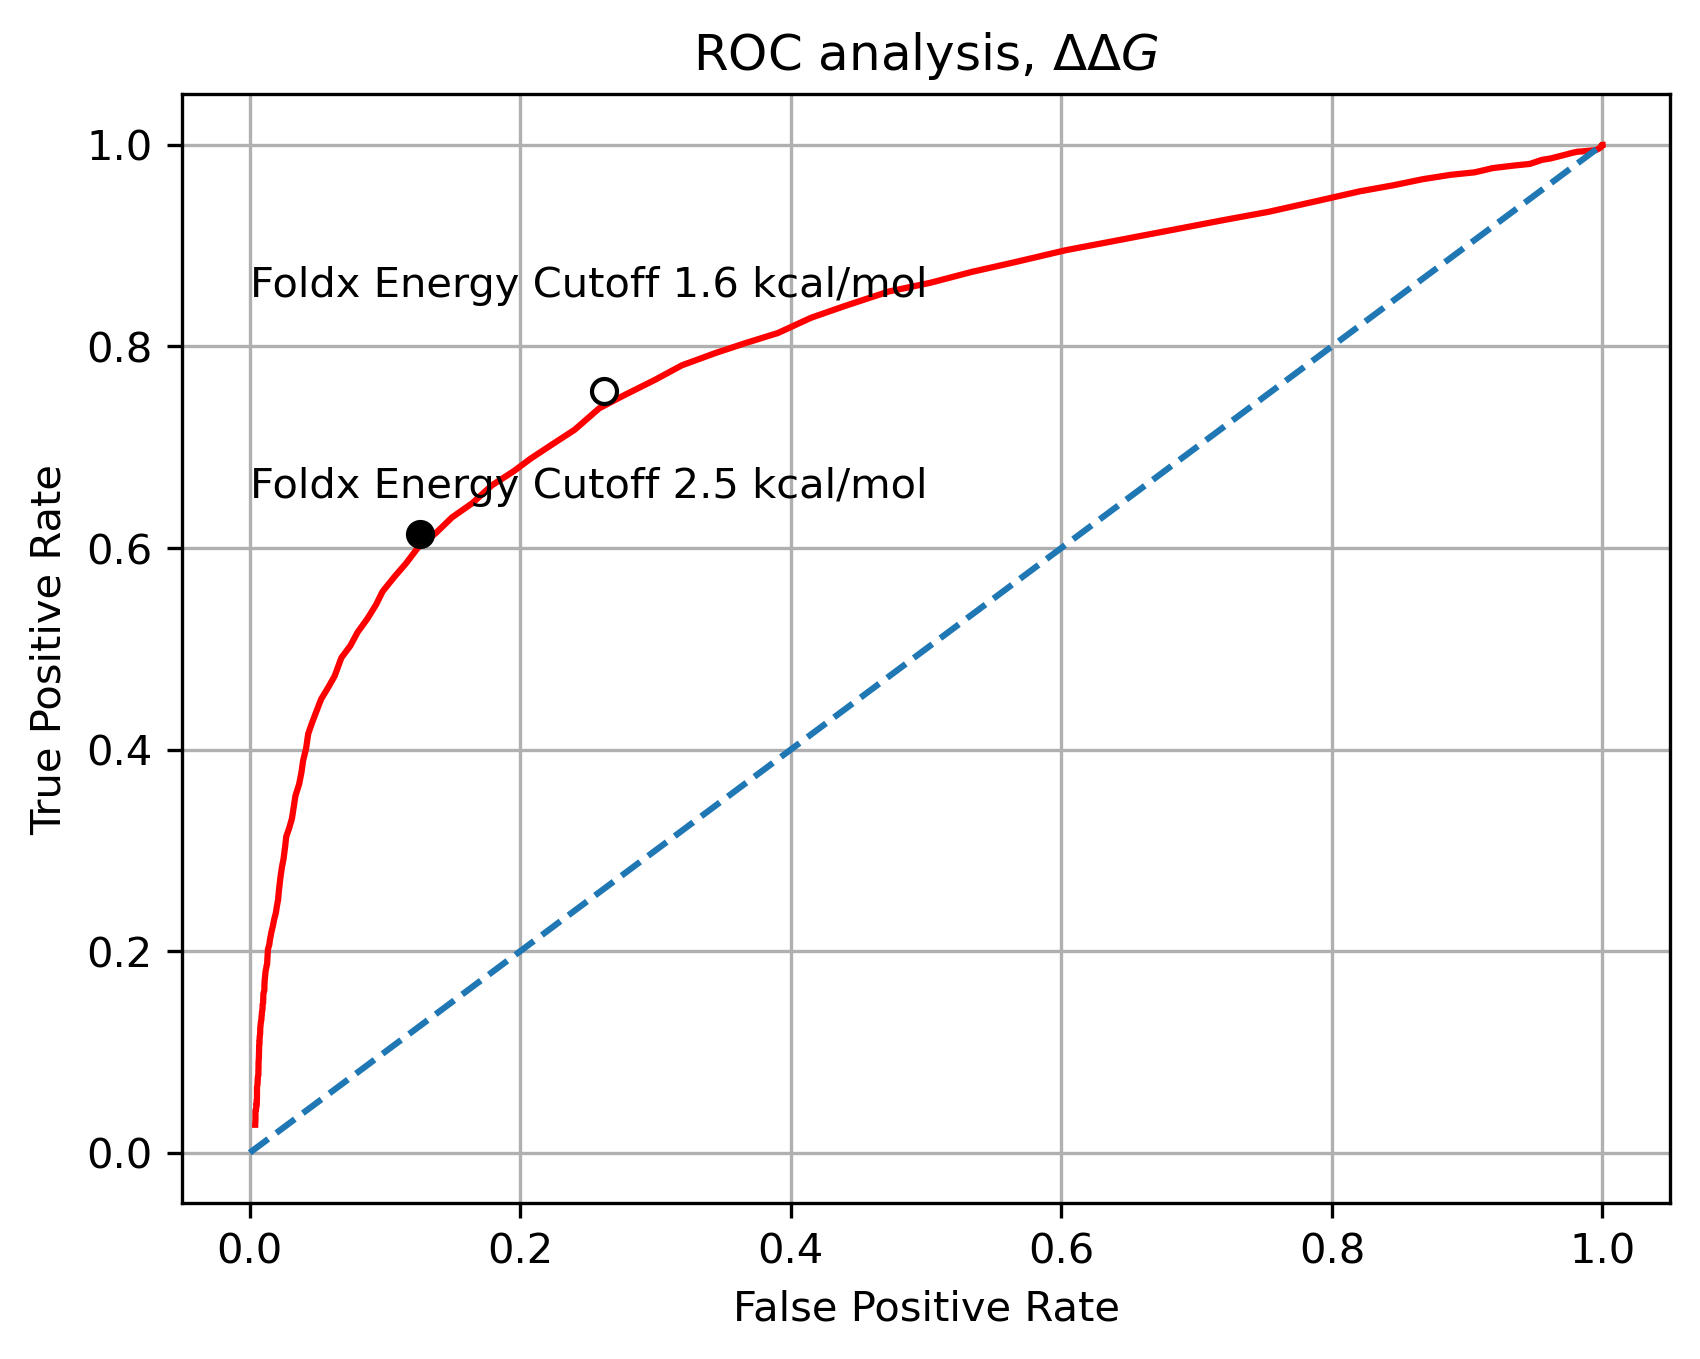

In [19]:
fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

g3 = sns.scatterplot(x = [0.262], y= [0.756], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
g4 = sns.scatterplot(x = [0.126], y= [0.614], zorder = 3, color = "black", edgecolor = "k", linewidth = 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, $\Delta \Delta G$")

plt.annotate("Foldx Energy Cutoff 1.6 kcal/mol", (0,0.85))
plt.annotate("Foldx Energy Cutoff 2.5 kcal/mol", (0,0.65))

plt.grid()
plt.savefig("Foldx_ROCcurve_v1.pdf")
plt.show()

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
72,2.2,0.178941,0.662083,0.741571
70,2.0,0.207695,0.688659,0.740482
71,2.1,0.195490,0.676452,0.740481


Now that we have actually got the graphs, what do they represent? How on earth does this tell us whether our classification model is good or not?

The answer lies under the curve. I'm talking about the area. So in the two plots above, we have two lines each. A red line and a blue dashed line. The red line as you may be able to guess is our data. That is our ROC curve for our dataset. So why is the blue line there?

Well if we look at the blue line, we see that it's just a straight line through the origin. We can also see that it intersects the corners of the grids. So we can see that the true positive rate = false positive rate of the blue curve. Let's take a step back to when we defined what those rates were at the beginning to understand this.

If our true positive rate is the same as our false positive rate, that means our binary classification model has a 50% chance of correctly deducing positive data. So that would suggest that our binary classification model in that instance is random. Half the time it gets it right, half the time it's wrong. So based on that analogy, one may say that the blue line must be a very bad model. It randomly classes the data! And it is a bad model. But we can't figure out these percentages for lines like the red one where it's constantly changing as the threshold changes.

That's why we often quantify the performance of our classification models with "AUC" values. AUC stands for "area underneath curve". So we would like to take a look at the area underneath the red curve to see if our classification model is a good fit. The blue curve has an area of 0.5. We know that 0.5 is a bad fit, so we would want to look for anything above 0.5.

But actually, what's accepted as a good model would have an AUC of about 0.8 or higher. 0.9 or higher is regarded as outstanding.

I believe this is one of the keys of our group project. We want to maximise the area underneath the red curve, so to make our classification model better.

In [21]:
predlist = []
roc_curvedata = []
for i in np.arange(2.8,30, 0.1):
    pred = []
    for item in plotting_frame["dnaDist"]:
        predvalue = 0 if item >= i else 1 # change this line based on the data!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)

roc_dataframe2 = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

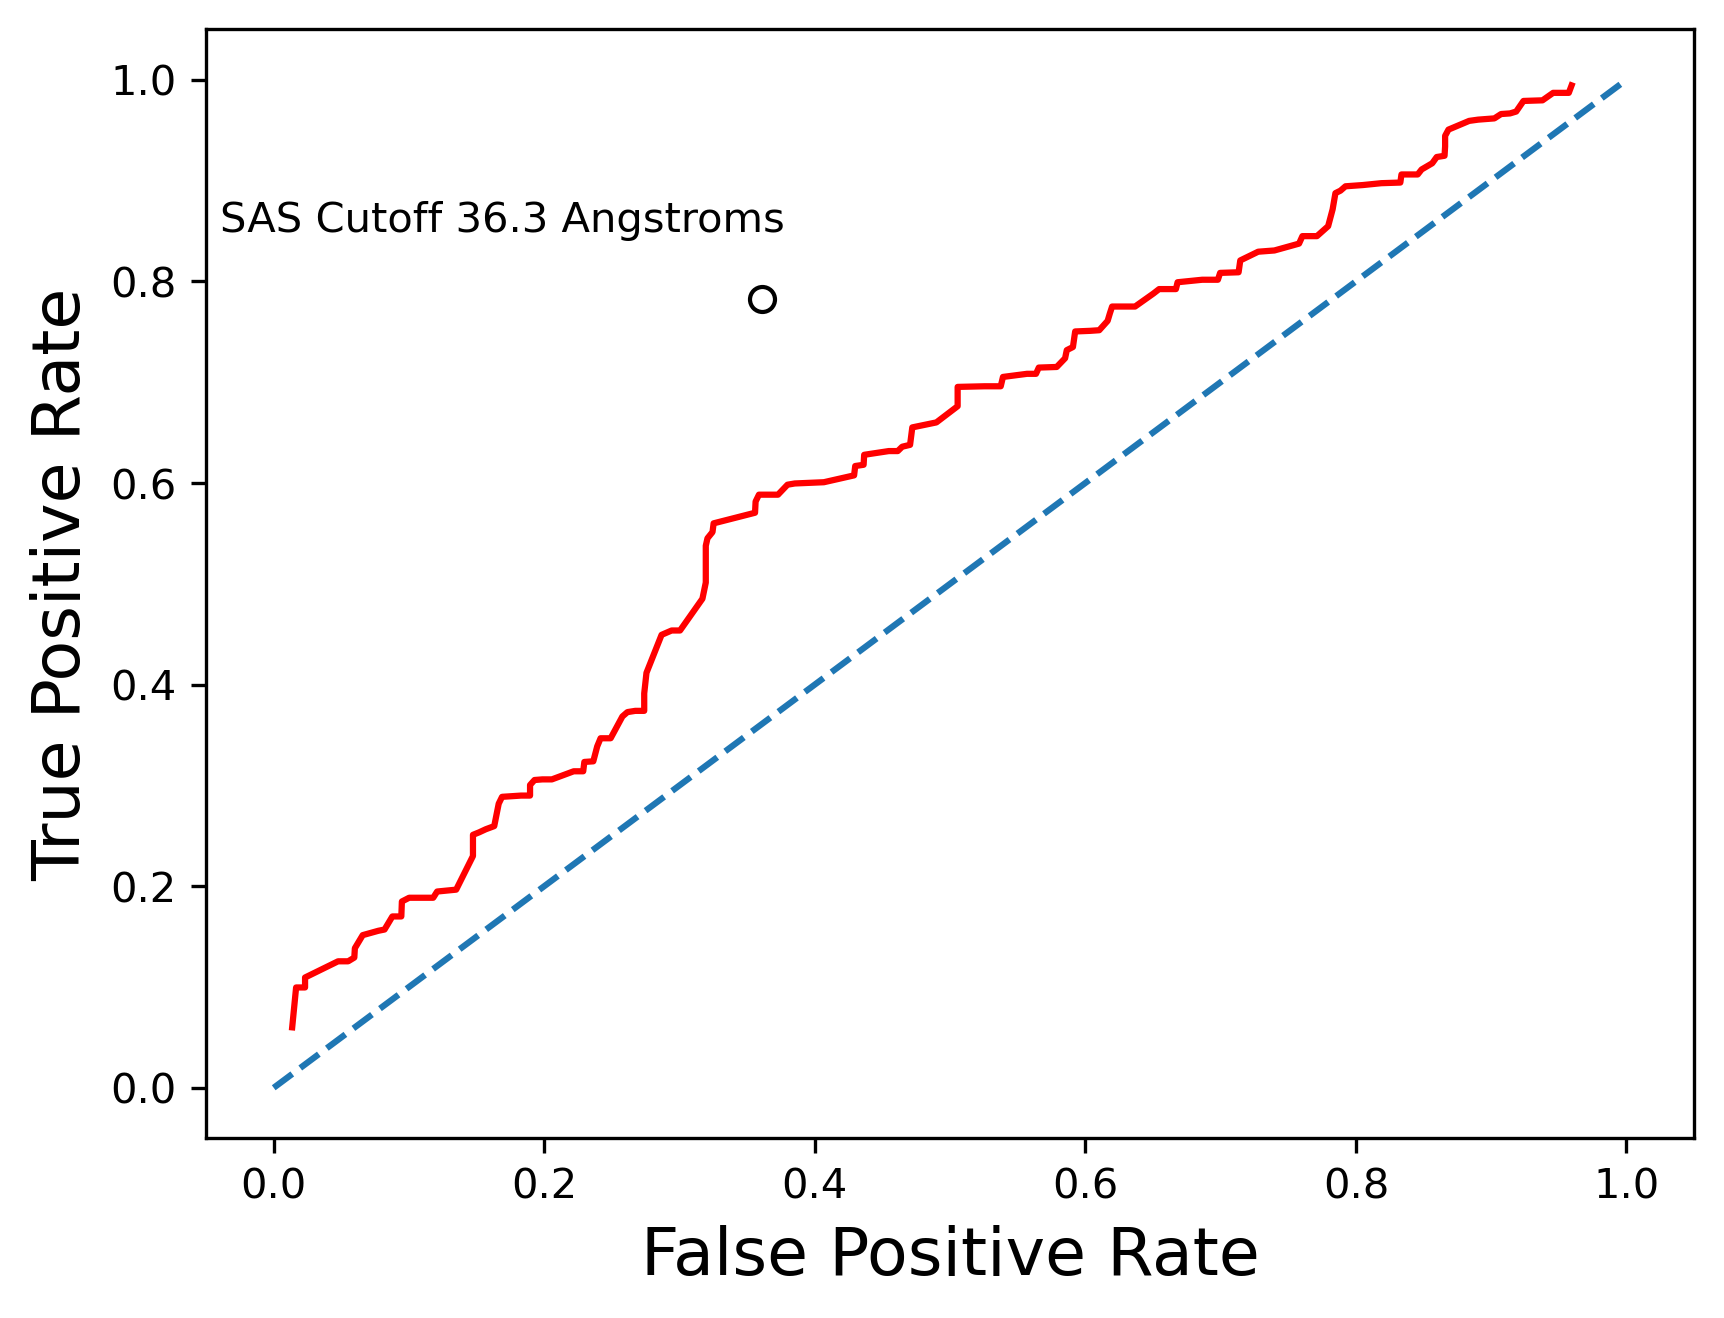

In [22]:
fig,ax = plt.subplots()
g = plt.plot(roc_dataframe2["fpr"], roc_dataframe2["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

#g3 = sns.scatterplot(x = [0.286], y= [0.777], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
#plt.annotate("Binding Site Distance Cutoff 11.3 anstroms", (-0.04,0.85), ha = "left")
plt.xlabel("False Positive Rate", size = 16)
plt.ylabel("True Positive Rate", size =16)
plt.annotate("SAS Cutoff 36.3 Angstroms", (-0.04,0.85), ha = "left")
g3 = sns.scatterplot(x = [0.361], y= [0.783], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
plt.savefig("Distance_ROCcurve_v1.pdf")
plt.show()

In [23]:
roc_auc

0.5174918544119654